<a href="https://colab.research.google.com/github/farielshafee2018/JPMorgan-finance-data/blob/main/Copy_of_gas_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

In [ ]:
df = pd.read_csv("/content/Nat_Gas.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [ ]:
df.isnull().sum()

,0
Dates,0
Prices,0


In [ ]:
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


check type of dates

In [ ]:
print(df['Dates'].dtype)

object


convert dates to datetime format

In [ ]:
df["Dates"]=pd.to_datetime(df["Dates"])

/tmp/ipython-input-3749837808.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Dates"]=pd.to_datetime(df["Dates"])


In [ ]:
df.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


plot the data

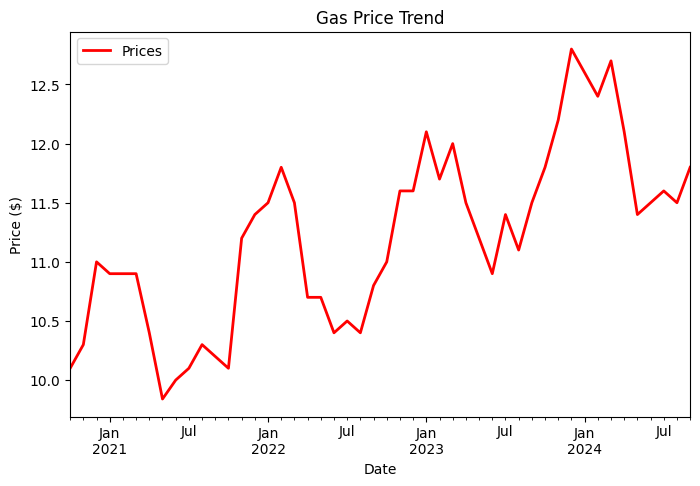

In [ ]:
df.plot(x='Dates', y='Prices', kind='line', figsize=(8, 5), color='red', linewidth=2)

plt.title('Gas Price Trend')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

We observe a nice pattern that peaks every January superposed on a linear upward trend.  The seasonal trend and the steady drift upwards are two components.  So we use the SARIMA model

Fit data first

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df_indexed = df.set_index('Dates')

# --- 2. Define and Fit the SARIMA Model ---

# Define the model parameters
# Non-seasonal order: (p, d, q)
order = (2, 1, 1)
# Seasonal order: (P, D, Q, s) - s=12 for monthly seasonality
seasonal_order = (1, 1, 0, 12)

print(f"\n--- Fitting SARIMA{order}{seasonal_order} Model ---")

# Initialize and fit the SARIMAX model
# We use SARIMAX instead of ARIMA because it supports seasonality
sarima_model = SARIMAX(
    df_indexed['Prices'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_model_fit = sarima_model.fit(disp=False) # disp=False suppresses optimization output

print(sarima_model_fit.summary())


--- Fitting SARIMA(2, 1, 1)(1, 1, 0, 12) Model ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                              Prices   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                   2.399
Date:                             Sat, 08 Nov 2025   AIC                              5.203
Time:                                     18:44:53   BIC                             10.425
Sample:                                 10-31-2020   HQIC                             6.336
                                      - 09-30-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9581      0.432     -2.218      0.027      -1.805      -0.111
ar.L2         -0.4598      

In [ ]:
df_indexed.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


now predict price one year into future

<Figure size 1200x600 with 0 Axes>

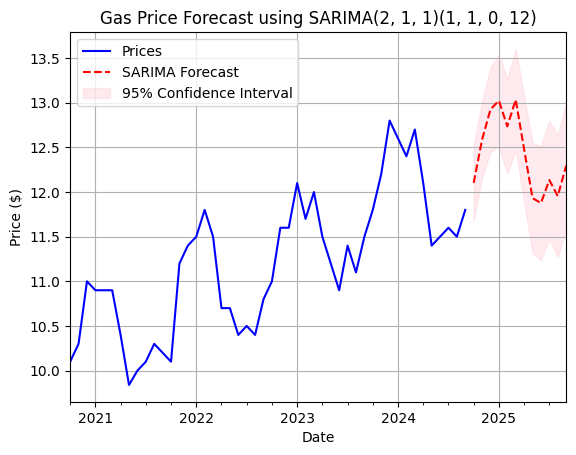


--- Forecast for the Next 12 Months ---
2024-10-31    12.102585
2024-11-30    12.587272
2024-12-31    12.925336
2025-01-31    13.023178
2025-02-28    12.735254
2025-03-31    13.034031
2025-04-30    12.478808
2025-05-31    11.932463
2025-06-30    11.876209
2025-07-31    12.134594
2025-08-31    11.954422
2025-09-30    12.294896
Freq: ME, Name: predicted_mean, dtype: float64


In [ ]:
# --- 3. Forecast the Future 1 Year (12 months) ---
forecast_steps = 12

# Generate the forecast results
forecast_results = sarima_model_fit.get_forecast(steps=forecast_steps)

# Extract the mean forecast and confidence intervals
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# Plotting the historical data and the forecast
plt.figure(figsize=(12, 6))

# Plot historical data
df_indexed.plot(label='Historical Price', color='blue')

# Plot the forecast
forecast_mean.plot(label='SARIMA Forecast', color='red', linestyle='--')

# Plot the 95% Confidence Interval
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink',
                 alpha=0.3,
                 label='95% Confidence Interval')

plt.title(f'Gas Price Forecast using SARIMA{order}{seasonal_order}')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Forecast for the Next 12 Months ---")
print(forecast_mean)

We predict gas price estimate for any date by
1. checking whether the date is within range defined by historic and predicted data
2. looking at the price at the beginning of the month and at the beginning of the next month, and then using linear interpolation

In [ ]:

from datetime import timedelta

def get_interpolated_price_eom(date_str, historical_series, forecast_series, ci_series):
    """
    Finds the estimated price for any day using linear interpolation between
    surrounding END-OF-MONTH prices.
    """
    date_to_find = pd.to_datetime(date_str)

    # 1. Combine historical and forecast means
    combined_series = pd.concat([historical_series, forecast_series])

    # Ensure the date is within the bounds
    if date_to_find < combined_series.index.min() or date_to_find > combined_series.index.max():
        return f"Error: Date {date_to_find.date()} is outside the full modeled range."

    # --- 2. Find the surrounding End-of-Month (EOM) dates ---

    # Find the EOM date *on or before* the date_to_find (the floor)
    # This involves calculating the EOM for the month of the input date
    date_floor = date_to_find + pd.offsets.MonthEnd(0) # MonthEnd(0) gives EOM of current month

    # If the input date is NOT an EOM, we need to find the EOM of the PREVIOUS month
    if date_to_find.day != date_floor.day:
        date_floor = date_to_find + pd.offsets.MonthEnd(-1)

    # The 'Ceil' is the next EOM date (the known point after the floor)
    date_ceil = date_floor + pd.offsets.MonthEnd(1)

    # If the floor is the very last point, we can't interpolate forward
    if date_floor == combined_series.index[-1]:
        price = combined_series.loc[date_floor]
        return f"Exact price found on {date_floor.date()}: ${price:.4f}"

    # --- 3. Retrieve Prices for EOM Bounds ---
    P_floor = combined_series.loc[date_floor]
    P_ceil = combined_series.loc[date_ceil]

    # --- 4. Calculate Days and Gradient ---
    total_days = (date_ceil - date_floor).days
    days_elapsed = (date_to_find - date_floor).days
    price_diff = P_ceil - P_floor
    gradient = price_diff / total_days

    # --- 5. Interpolate and Return Price ---
    estimated_price = P_floor + (gradient * days_elapsed)

    data_type = "HISTORICAL (Interpolated)" if date_to_find <= historical_series.index.max() else "PREDICTED (Interpolated)"

    output = [f"**{data_type}** estimated price on {date_to_find.date()}: **${estimated_price:.4f}**"]

    # Interpolate Confidence Interval (CI) for predicted dates
    if 'PREDICTED' in data_type:
        CI_floor_low = ci_series.loc[date_floor].iloc[0]
        CI_ceil_low = ci_series.loc[date_ceil].iloc[0]
        CI_low = CI_floor_low + ((CI_ceil_low - CI_floor_low) / total_days * days_elapsed)

        CI_floor_high = ci_series.loc[date_floor].iloc[1]
        CI_ceil_high = ci_series.loc[date_ceil].iloc[1]
        CI_high = CI_floor_high + ((CI_ceil_high - CI_floor_high) / total_days * days_elapsed)

        output.append(f"   (Estimated 95% Confidence Range: ${CI_low:.4f} to ${CI_high:.4f})")

    return '\n'.join(output)



Our historical series is df_indexed.  

In [ ]:
historical_series=df_indexed

find the price for any date within range


put all these functions together into a big function that takes in an input date

/tmp/ipython-input-1267209053.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Dates"]=pd.to_datetime(df["Dates"])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


--- 2. Fitting SARIMA Model... ---
Forecast Data Range: 2024-10-31 to 2025-09-30
Setup complete. Model ready for prediction.

Enter a date (2020-10-31 to 2025-09-30, e.g., 2023-05-15): 2023-11-11

RESULT FOR DATE: 2023-11-11
Data Type: HISTORICAL (Interpolated Estimate)
Estimated Gas Price: **$11.9467**
